# Imports & Settings

In [1]:
from typing import Optional

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy.stats import loguniform, uniform

from sklearn.compose import ColumnTransformer
from sklearn.dummy import DummyRegressor
from sklearn.linear_model import LinearRegression, Lasso, Ridge, ElasticNet
from sklearn.metrics import make_scorer, mean_squared_error as mse, r2_score as r2
from sklearn.model_selection import cross_validate, learning_curve, train_test_split
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, StratifiedKFold
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder, PolynomialFeatures

In [2]:
# Enable diagrams to visualize pipelines
from sklearn import set_config
set_config(display="diagram")

# Functions

In [3]:
def plot_learning_curves(model,
                         metric = "r2", cv: int = 10,
                         out: bool = False) -> None:
    """
    `out` set to True allows to export the graph in png format
    in the viz/graphs folder.
    """
    # the estimator is the pipeline's last element
    model_name = model[-1].__class__.__name__
    # in case of custom estimator, get its __name__ attribute
    try:
        metric_name = metric.__name__
    except AttributeError:
        metric_name = metric
    
    train_sizes, train_scores, test_scores = learning_curve(
        model,
        X_train, y_train,
        train_sizes=np.linspace(0.1, 1.0, 10), # 10 train sizes with cumulative 10%
        cv=cv,
        scoring=metric, # Default None. str
        n_jobs=-1,
        return_times=False # Switch if you want fit and score times
    )

    # take the mean of cross-validated train score and validation score
    # if scores are negative, take the absolute value
    train_scores_means = np.abs(np.mean(train_scores, axis=1))
    test_scores_means = np.abs(np.mean(test_scores, axis=1))

    # plotting
    plt.figure(figsize=(12, 6))
    plt.plot(train_sizes, train_scores_means, label="Training Score")
    plt.plot(train_sizes, test_scores_means, label="Validation Score")
    plt.ylabel(f"{metric_name} Score", size="large", weight="bold")
    plt.xlabel("Training Set Size", size="large", weight="bold")
    plt.title(f"Learning Curves for {model_name} with {metric_name}",
              size="x-large", weight="bold", c="b")
    plt.grid(ls="--")
    plt.legend(loc="best")

    if out:
        plt.savefig(f"viz/graphs/lc_{model_name}_{metric}.png", dpi=300)
        
    plt.show()

In [4]:
def rmse_scorer(y_true, y_pred):
    return np.sqrt(mse(y_true, y_pred))

In [5]:
def split_bmi_in_three(x: float) -> str:
    if x < 25:
        return "underweight_normal"
    if x < 30:
        return "overweight"
    return "obesity"

# Data Loading & Separating

In [6]:
df = pd.read_csv("csvs/cleaned_dataset.csv")

In [7]:
y = df.pop("charges")
X = df

# Preprocessing

## Modifying `y`'s Shape

<font color="orangered">**On EDA's notebook §9 was showed the target's skewness, here's to correct it.**

In [8]:
y = np.log(y + 1)

## Preprocessing 1

> 👉 <font color="orangered">**We'll scale our three numerical variables, as it is, theoretically,  > better in order to use a linear model.**</font>
>
> PS: There's still a doubt about considering or not `bmi`, which is continuous, as a nominal variable. If there's time and room to use both approaches, then it will be done later.

In [9]:
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1337 entries, 0 to 1336
Data columns (total 6 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       1337 non-null   int64  
 1   sex       1337 non-null   object 
 2   bmi       1337 non-null   float64
 3   children  1337 non-null   int64  
 4   smoker    1337 non-null   object 
 5   region    1337 non-null   object 
dtypes: float64(1), int64(2), object(3)
memory usage: 62.8+ KB


### Hold-Out 1

In [10]:
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    shuffle=True,
                                                    train_size=0.85,
                                                    random_state=42,
                                                    stratify=X['smoker'])

### Pipe 1

In [11]:
num_cols_1 = X.select_dtypes(exclude="object").columns
bin_cols = ["sex", "smoker"]
ohe_cols_1 = ["region"]

In [12]:
num_cols_1, bin_cols, ohe_cols_1

(Index(['age', 'bmi', 'children'], dtype='object'),
 ['sex', 'smoker'],
 ['region'])

In [13]:
preproc_1 = ColumnTransformer([
    ("num", StandardScaler(), num_cols_1),
    ("bin", OneHotEncoder(drop="if_binary", handle_unknown="ignore"), bin_cols),
    ("ohe", OneHotEncoder(drop="first", handle_unknown="ignore"), ohe_cols_1)
])

In [14]:
preproc_1

ColumnTransformer(transformers=[('num', StandardScaler(),
                                 Index(['age', 'bmi', 'children'], dtype='object')),
                                ('bin',
                                 OneHotEncoder(drop='if_binary',
                                               handle_unknown='ignore'),
                                 ['sex', 'smoker']),
                                ('ohe',
                                 OneHotEncoder(drop='first',
                                               handle_unknown='ignore'),
                                 ['region'])])

## Preprocessing 2

### Bucketizing `bmi`

☝️ <font color="orangered">**First of all, we will transform `bmi` into a nominal variable.**</font>

In [15]:
X_bmi_bin = X.copy()

In [16]:
X_bmi_bin.bmi = X_bmi_bin.bmi.apply(split_bmi_in_six)
X_bmi_bin.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1337 entries, 0 to 1336
Data columns (total 6 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   age       1337 non-null   int64 
 1   sex       1337 non-null   object
 2   bmi       1337 non-null   object
 3   children  1337 non-null   int64 
 4   smoker    1337 non-null   object
 5   region    1337 non-null   object
dtypes: int64(2), object(4)
memory usage: 62.8+ KB


### Holt-Out 2

In [37]:
X_bmi_bin_train, X_bmi_bin_test, y_train, y_test =\
train_test_split(X_bmi_bin, y,
                 shuffle=True,
                 train_size=0.85,
                 random_state=42,
                 stratify=X['smoker'])

In [38]:
num_cols_2 = ["age", "children"]
ohe_cols_2 = ["bmi", "region"]

In [39]:
preproc_2 = ColumnTransformer([
    ("num", StandardScaler(), num_cols_2),
    ("bin", OneHotEncoder(drop="if_binary", handle_unknown="ignore"), bin_cols),
    ("ohe", OneHotEncoder(drop="first", handle_unknown="ignore"), ohe_cols_2)
])

In [40]:
preproc_2

ColumnTransformer(transformers=[('num', StandardScaler(), ['age', 'children']),
                                ('bin',
                                 OneHotEncoder(drop='if_binary',
                                               handle_unknown='ignore'),
                                 ['sex', 'smoker']),
                                ('ohe',
                                 OneHotEncoder(drop='first',
                                               handle_unknown='ignore'),
                                 ['bmi', 'region'])])

# Adding Estimators to End Pipelines

In [41]:
pipe_1_lr = make_pipeline(preproc_1, LinearRegression())
pipe_1_en = make_pipeline(preproc_1, ElasticNet(random_state=42))

pipe_2_lr = make_pipeline(preproc_2, LinearRegression())
pipe_2_en = make_pipeline(preproc_2, ElasticNet(random_state=42))

In [23]:
pipe_1_lr

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('num', StandardScaler(),
                                                  Index(['age', 'bmi', 'children'], dtype='object')),
                                                 ('bin',
                                                  OneHotEncoder(drop='if_binary',
                                                                handle_unknown='ignore'),
                                                  ['sex', 'smoker']),
                                                 ('ohe',
                                                  OneHotEncoder(drop='first',
                                                                handle_unknown='ignore'),
                                                  ['region'])])),
                ('linearregression', LinearRegression())])

In [24]:
pipe_1_en

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('num', StandardScaler(),
                                                  Index(['age', 'bmi', 'children'], dtype='object')),
                                                 ('bin',
                                                  OneHotEncoder(drop='if_binary',
                                                                handle_unknown='ignore'),
                                                  ['sex', 'smoker']),
                                                 ('ohe',
                                                  OneHotEncoder(drop='first',
                                                                handle_unknown='ignore'),
                                                  ['region'])])),
                ('elasticnet', ElasticNet(random_state=42))])

In [42]:
pipe_2_lr

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('num', StandardScaler(),
                                                  ['age', 'children']),
                                                 ('bin',
                                                  OneHotEncoder(drop='if_binary',
                                                                handle_unknown='ignore'),
                                                  ['sex', 'smoker']),
                                                 ('ohe',
                                                  OneHotEncoder(drop='first',
                                                                handle_unknown='ignore'),
                                                  ['bmi', 'region'])])),
                ('linearregression', LinearRegression())])

In [43]:
pipe_2_en

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('num', StandardScaler(),
                                                  ['age', 'children']),
                                                 ('bin',
                                                  OneHotEncoder(drop='if_binary',
                                                                handle_unknown='ignore'),
                                                  ['sex', 'smoker']),
                                                 ('ohe',
                                                  OneHotEncoder(drop='first',
                                                                handle_unknown='ignore'),
                                                  ['bmi', 'region'])])),
                ('elasticnet', ElasticNet(random_state=42))])

# Raw Cross-Validation

## 🚸 `StratifiedKFold` Implementation

> **MOTIVATION**
>
> We previously took care to stratify `smoker` in *test* set.
>
> We now have to take care to stratify it in *train* set too.
>
> In order to do that, we can create a `FeatureStratifiedKFold` class, based upon `StratifiedKFold`.

In [78]:
# class FeatureStratifiedKFold:
#     def __init__(self,
#                  n_splits: int = 10, shuffle: bool = True,
#                  random_state: Optional[int] = None):
#         self.n_splits = n_splits
#         self.shuffle = shuffle
#         self.random_state = random_state

#     def split(self, X, y=None):
#         stratity_by = X["smoker"]
#         sfk = StratifiedKFold(n_splits=self.n_splits, 
#                               shuffle=self.shuffle,
#                               random_state=self.random_state)
#         return skf.split(X, stratify_by)

#     def get_n_splits(self, X=None, y=None):
#         return self.n_splits

In [79]:
# feature_stratified_cv = FeatureStratifiedKFold(random_state=42)

## `LinearRegression` with preprocessing 1

### Trainings and Results

In [44]:
%%time

res_1_lr = cross_validate(
    pipe_1_lr,
    X_train, y_train,
    cv=10,
    scoring = "r2",
    n_jobs=-1
)

CPU times: user 82.6 ms, sys: 112 ms, total: 195 ms
Wall time: 1.05 s


In [45]:
pd.DataFrame(res_1_lr)

,fit_time,score_time,test_score
0,0.014689,0.007761,0.654832
1,0.012499,0.005057,0.811772
2,0.010693,0.004520,0.769860
3,0.017375,0.008421,0.771066
4,0.009757,0.004412,0.691802
5,0.012650,0.005016,0.843344
6,0.009789,0.004262,0.727097
7,0.013149,0.007536,0.736192
8,0.011640,0.003729,0.755025
9,0.016135,0.006857,0.654486


### Score on train set

In [46]:
pipe_1_lr.fit(X_train, y_train)
pipe_1_lr.score(X_test, y_test)

0.8404852830432452

## `ElasticNet` with preprocessing 1

### Trainings and Results

In [47]:
%%time

res_1_en = cross_validate(
    pipe_1_en,
    X_train, y_train,
    cv=10,
    scoring = "r2",
    n_jobs=-1
)

CPU times: user 12.1 ms, sys: 12.4 ms, total: 24.4 ms
Wall time: 556 ms


In [48]:
pd.DataFrame(res_1_en)

,fit_time,score_time,test_score
0,0.009563,0.004294,-0.001118
1,0.008280,0.003487,-0.007625
2,0.009001,0.004098,-0.006776
3,0.008770,0.003772,-0.000694
4,0.009544,0.004182,-0.060108
5,0.009644,0.004752,-0.009554
6,0.016834,0.006742,-0.004785
7,0.016087,0.007613,-0.016696
8,0.015282,0.006051,-0.153869
9,0.015796,0.006804,-0.033521


### Score on test set

In [49]:
pipe_1_lr.fit(X_train, y_train)
pipe_1_lr.score(X_test, y_test)

0.8404852830432452

## Learning Curves

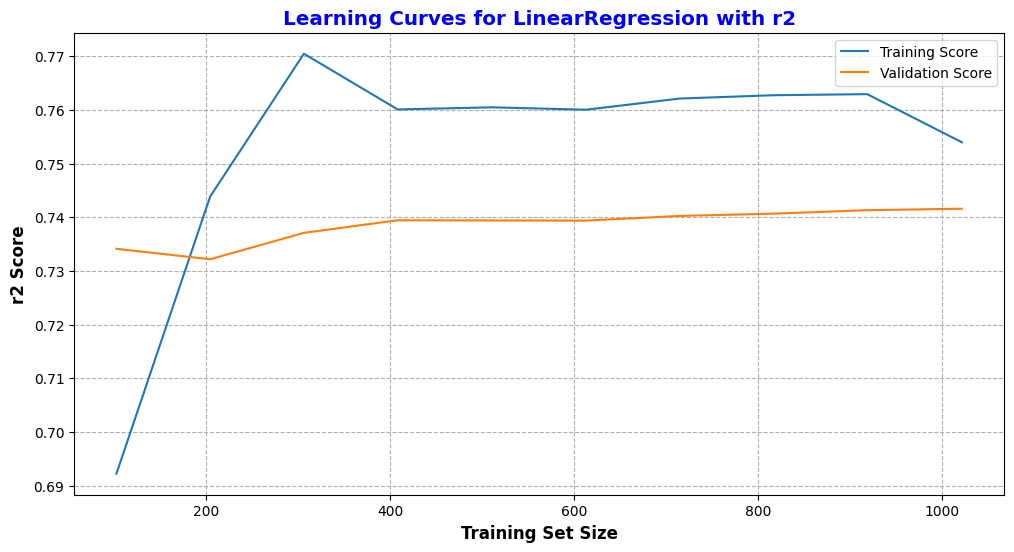

In [57]:
plot_learning_curves(pipe_1_lr)

In [58]:
pipe_1_lr.fit(X_train, y_train)

pipe_1_lr.score(X_test, y_test)

0.8404852830432452

### `rmse`

In [58]:
# Define the scorer
rmse = make_scorer(rmse_scorer, greater_is_better=False)

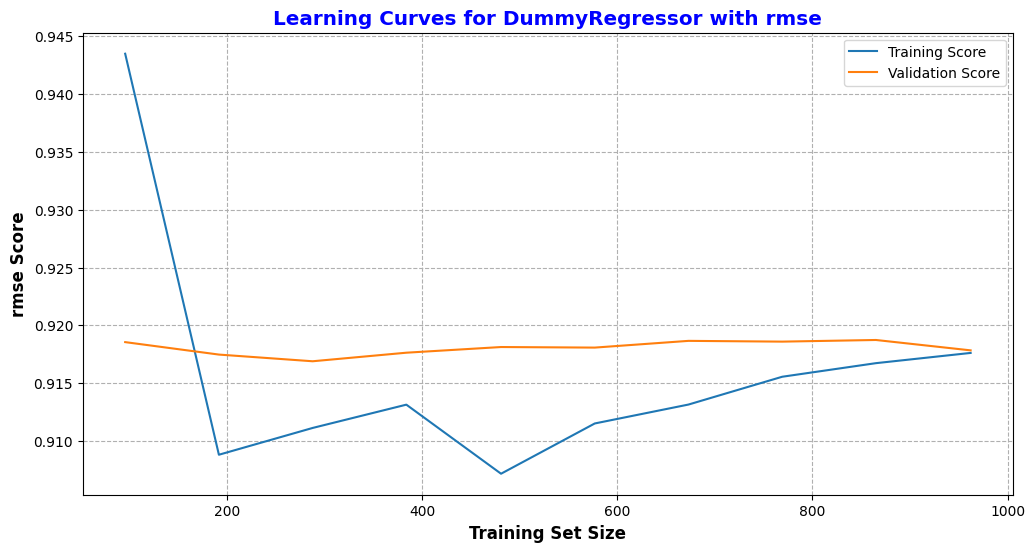

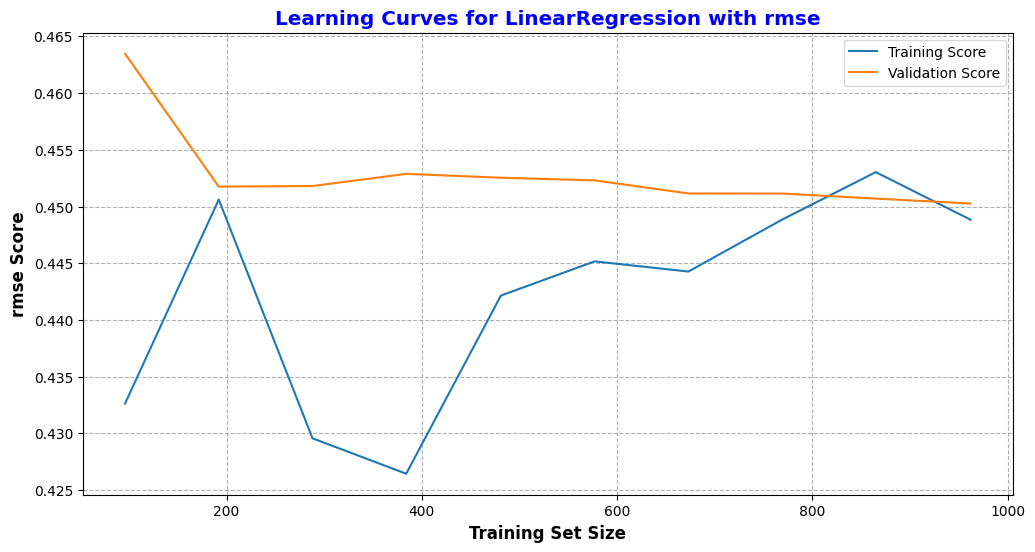

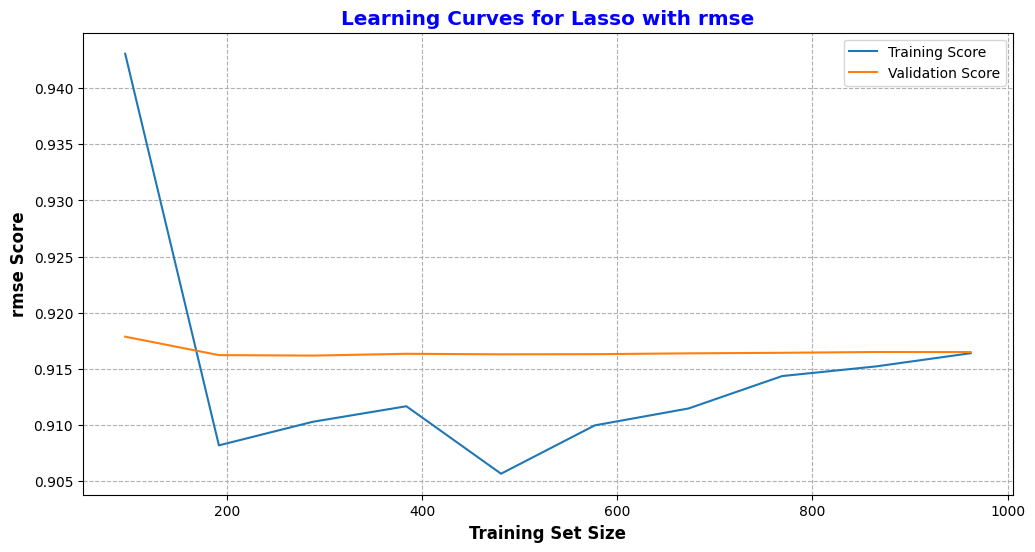

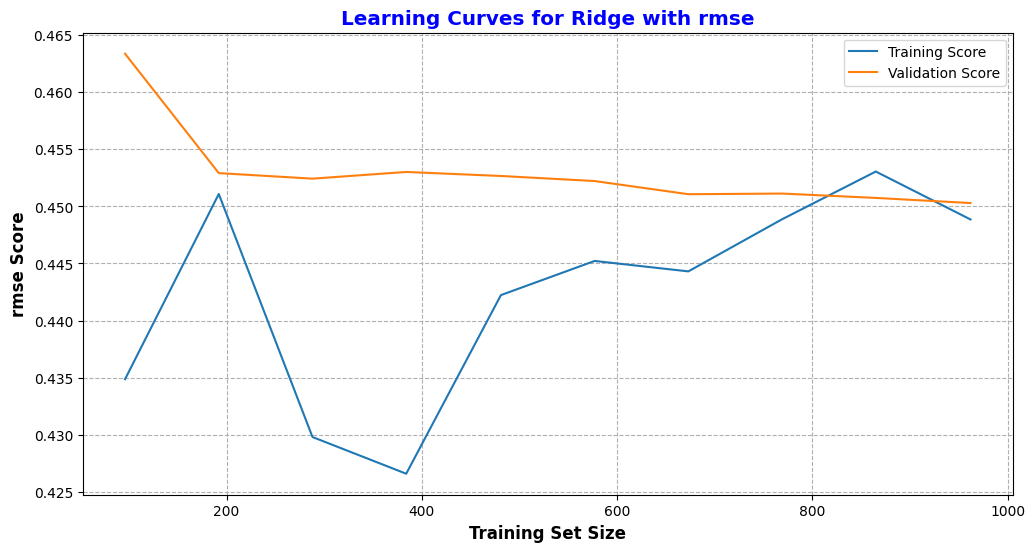

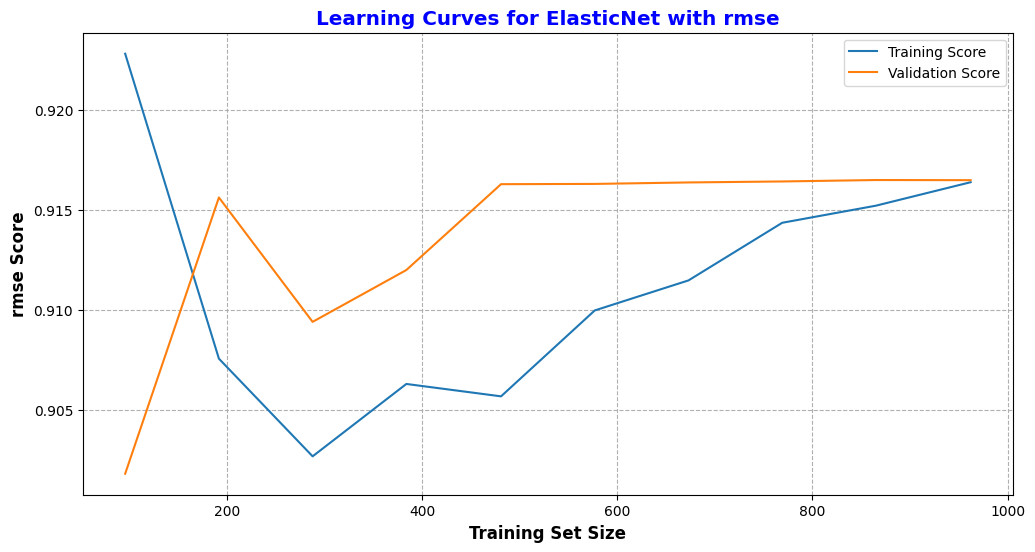

In [96]:
for model in models_1:
    plot_learning_curves(model, metric=rmse)

# `RandomizedSearchCV`

## Grids

In [101]:
params = {
    "elasticnet__alpha": uniform(1e-5, 1),
    "elasticnet__l1_ratio": loguniform(0, 1)
}

In [106]:
poly = PolynomialFeatures(degree=2)

In [107]:
pipe_1_pf_en = make_pipeline(preproc_1,
                             poly,
                             ElasticNet(random_state=42))

In [111]:
%%time

poly = PolynomialFeatures(degree=2)
X_train_poly = pipe_1_pf_en[:-1].fit_transform(X_train)

n_iter_search = 500

random_search = RandomizedSearchCV(pipe_1_en,
                                   param_distributions=params,
                                   n_iter = n_iter_search,
                                   cv = 10,
                                   n_jobs=-1)

random_search.fit(X_train_poly, y_train)

ValueError: Domain error in arguments. The `scale` parameter must be positive for all distributions, and many distributions have restrictions on shape parameters. Please see the `scipy.stats.loguniform` documentation for details.

In [98]:
best_model = random_search.best_estimator_

In [99]:
random_search.best_params_

{'elasticnet__alpha': 0.000583364042267599,
 'elasticnet__l1_ratio': 0.414604692345918}

In [100]:
best_model.fit(X_train, y_train)
best_model.score(X_test, y_test)

0.8407542607097498